In [1]:
import math
import os
from methods import Segmenter, TransformerModel, LSTM, CRNN, UNet,CCRNN, UNet2, PatchTST
from matplotlib import pyplot as plt
import torch
from methods.unetc import UNetc
from methods.unetr import UNetrt
from utilities import printc, seed
from utils_loader import get_dataloaders, test_idea_dataloader_ABC_to_BCA, test_idea_dataloader_long_A_B_to_AB
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from utils_metrics import eval_dense_label_to_classification, mean_iou, visualize_softmax
from torch.nn import functional as F

In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from utilities import sliding_windows
import torch

def load_data():
    filename = './datasets/spar/spar_dataset'
    # read through the folder that end with csv:
    sw = sliding_windows(300, 150)
    def process(files, sw, le: LabelEncoder):
        nps = []
        labels = []
        for file in files:
            df = pd.read_csv(os.path.join(filename, file))
            nps.append(df.to_numpy()[:, 1:7])
            labels.append([le.transform([file.split('_')[1]])[0]]*df.shape[0])
        nps = np.concatenate(nps, axis=0)
        labels = np.concatenate(labels, axis=0)
        return sw(torch.tensor(nps).float(), torch.tensor(labels))
    
    classes = []
    subjs = []
    for root, dirs, files in os.walk(filename):
        for file in files:
            if file.endswith(".csv") and 'R' in file:
                label = file.split('_')[1]
                subj = file.split('_')[0]
                if label not in classes:
                    classes.append(label)
                if subj not in subjs:
                    subjs.append(subj)
    
    le = LabelEncoder()
    le.fit(classes)
    
    # read through the folder that end with csv:
    samples = []
    labels = []
    for each_subj in subjs:
        collection = {class_name: [] for class_name in classes}
        for root, dirs, files in os.walk(filename):
            for file in files:
                if file.endswith(".csv") and 'R' in file and each_subj == file.split('_')[0]:
                    label = file.split('_')[1]
                    collection[label].append(file)
        leftover = []
        for key in collection:
            # sort the files
            sorted_files = sorted(collection[key], key=lambda x: int(x.split('_')[3].split('.')[0]))
            sample, lab = process(sorted_files, sw, le)
            samples.append(sample)
            labels.append(lab)
    samples = torch.cat(samples, dim=0)
    labels = torch.cat(labels, dim=0)
    return samples, labels
    

def load_data1():
    filename = './datasets/spar/spar_dataset'
    seed = 0
    # read through the folder that end with csv:
    def combo_to_np(combo, le: LabelEncoder):
        samples = []
        labels = []
        for each_combo in combo:
            for each_file in each_combo:
                df = pd.read_csv(os.path.join(filename, each_file))
                samples.append(df.to_numpy()[:, 1:7])
                transformed = le.transform([each_file.split('_')[1]])[0] + 1
                labels.append([transformed] * df.shape[0])
                # print('labels', labels)
        # convert to np:
        samples = np.concatenate(samples)
        labels = np.concatenate(labels)
        # print(samples.shape, labels.shape)
        return samples, labels
    
    if True:
        filename = './datasets/spar/spar_dataset'
        seed = 0
        # read through the folder that end with csv:
        classes = []
        subjs = []
        for root, dirs, files in os.walk(filename):
            for file in files:
                if file.endswith(".csv") and 'R' in file:
                    label = file.split('_')[1]
                    subj = file.split('_')[0]
                    if label not in classes:
                        classes.append(label)
                    if subj not in subjs:
                        subjs.append(subj)
                    # print(os.path.join(root, file))
                    # df = pd.read_csv(os.path.join(root, file))

        # generate train combo => ABC, ABD, ... # test combo => BCD (some combo that was not seem in train) based on the classes
        train_combo = [('E1', 'E2', 'E3')]
        test_combo = [('E3', 'E2', 'E1')]

        assert all([each in classes for comb in train_combo for each in comb]), 'train combo not in classes'
        assert all([each in classes for comb in test_combo for each in comb]), 'test combo not in classes'
        train_classes = list(set([each for comb in train_combo for each in comb]))
        le = LabelEncoder()
        le.fit(train_classes)
        random.seed(seed)
        train_samples = []
        test_samples = []
        for each_subj in subjs:
            collection = {class_name: [] for class_name in classes}
            for root, dirs, files in os.walk(filename):
                for file in files:
                    if file.endswith(".csv") and 'R' in file and each_subj == file.split('_')[0]:
                        label = file.split('_')[1]
                        collection[label].append(file)

            lengths = [len(collection[class_name]) for class_name in classes]
            minimum = min(lengths)
            # 80% for train, 20% for test
            train_length = int(minimum * 0.8)
            test_length = minimum - train_length
            # print(f'{each_subj} has {minimum} samples, {train_length} for train, {test_length} for test')
            # generate train and test data
            
            # randomly extract one sample of label from the collection and remove that label from the list in the collection:
            for _ in range(train_length):
                for i in train_combo:
                    cur_combo = []
                    for j in i:
                        selected_sample = random.choice(collection[j])
                        collection[j].remove(selected_sample)
                        cur_combo.append(selected_sample)
                    train_samples.append(cur_combo)
            for _ in range(test_length):
                for i in test_combo:
                    cur_combo = []
                    for j in i:
                        selected_sample = random.choice(collection[j])
                        collection[j].remove(selected_sample)
                        cur_combo.append(selected_sample)
                    test_samples.append(cur_combo)
        train_s = combo_to_np(train_samples, le)
        test_s = combo_to_np(test_samples, le)
    
    sw = sliding_windows(300, 150)
    
    train_samples, train_labels = sw(torch.tensor(train_s[0]), torch.tensor(train_s[1]))
    test_samples, test_labels = sw(torch.tensor(test_s[0]), torch.tensor(test_s[1]))
    # Split the dataset into train, val and test:
    train_samples, val_samples, train_labels, val_labels = train_test_split(train_samples, train_labels, test_size=0.2, random_state=42)
    return train_samples, val_samples, test_samples, train_labels, val_labels, test_labels

# samples, labels = load_data() 
train_samples, val_samples, test_samples, train_labels, val_labels, test_labels = load_data1()

    
    

In [3]:
# custom dataset for ctc:

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = self._get_labels_ctc(labels)
        self.sec_labels = labels
    def _get_labels_ctc(self, labels):
        # convert the labels to ctc format
        # [1, 1, 1, 2, 2, 2, 3, 3, 3] -> [1, 2, 3], 3
        lis = []
        
        # when the new label is different from the previous one, append the previous one to the list
        for i in range(len(labels)):
            cur_list = []
            prev = labels[i, 0]
            count = 1
            for j in range(1, len(labels[i])):
                if labels[i, j] == prev:
                    if j == len(labels[i]) - 1:
                        cur_list.append(prev)
                else:
                    cur_list.append(prev)
                    prev = labels[i, j]
                    count += 1
            cur_list = torch.tensor(cur_list)
            lis.append(cur_list)
        return lis
    @staticmethod
    def custom_collate_fn(x):
        batch = []
        labels = []
        lengths = []
        for i in range(len(x)):
            batch.append(x[i][0])
            labels.extend(x[i][1])
            lengths.append(len(x[i][1]))
            # lengths.append()
        batch = torch.stack(batch)
        labels = torch.tensor(labels)
        lengths = torch.tensor(lengths)
        return batch, labels, lengths
                
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        # target, target_length
        return self.samples[idx], self.labels[idx]

In [4]:
train_dataset = CustomDataset(train_samples, train_labels)
val_dataset = CustomDataset(val_samples, val_labels)
test_dataset = CustomDataset(test_samples, test_labels)

for i in range(len(train_dataset)):
    print(train_dataset[i])
    break


(tensor([[ 0.0349,  1.0595,  0.2088,  0.6428,  1.9648, -0.1645],
        [ 0.0464,  0.9939,  0.1085,  0.6062,  1.9830, -0.1459],
        [ 0.0426,  0.9146,  0.0546, -0.1829,  1.9559, -0.1445],
        ...,
        [ 0.2131, -0.0094, -0.5881, -0.4107,  3.2487, -0.3954],
        [ 0.2324, -0.0292, -0.4669, -0.1402,  3.2083, -0.3127],
        [ 0.3251, -0.0484, -0.4190,  0.1312,  3.1519, -0.2248]],
       dtype=torch.float64), tensor([3, 1, 2]))


In [5]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=CustomDataset.custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=CustomDataset.custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=CustomDataset.custom_collate_fn)

# z = next(iter(train_loader))
z = next(iter(test_loader))

In [6]:
# lstm:

class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out
    

In [10]:
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(6, 128, 1, 4).to(device)
criterion = torch.nn.CTCLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
total_step = len(train_loader)
for epoch in range(200):
    for i, (images, labels, labels_count) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        labels_count = torch.tensor(labels_count).to(device)
        # Forward pass
        images = images.float()
        outputs = model(images)
        outputs = F.log_softmax(outputs, dim=2)
        # print(outputs.shape, labels.shape, labels_count.shape)
        input_lengths = torch.full((images.shape[0],), images.shape[1], dtype=torch.long).to(device)
        loss = criterion(outputs.transpose(0, 1), labels.cpu(),  input_lengths.cpu(), labels_count.cpu())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{50}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')



/var/folders/9s/zgph6l3n6b75g5pycfr4d_n40000gn/T/ipykernel_44330/1389195309.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_count = torch.tensor(labels_count).to(device)


Epoch [1/50], Step [10/19], Loss: 91.8151
Epoch [2/50], Step [10/19], Loss: 4.9258
Epoch [3/50], Step [10/19], Loss: 22.2189
Epoch [4/50], Step [10/19], Loss: 21.5058
Epoch [5/50], Step [10/19], Loss: 6.5217
Epoch [6/50], Step [10/19], Loss: 8.8896
Epoch [7/50], Step [10/19], Loss: 21.4771
Epoch [8/50], Step [10/19], Loss: 7.1393
Epoch [9/50], Step [10/19], Loss: 21.2490
Epoch [10/50], Step [10/19], Loss: 21.0558
Epoch [11/50], Step [10/19], Loss: 5.3303
Epoch [12/50], Step [10/19], Loss: 33.6539
Epoch [13/50], Step [10/19], Loss: 37.1955
Epoch [14/50], Step [10/19], Loss: 9.3190
Epoch [15/50], Step [10/19], Loss: 21.4430
Epoch [16/50], Step [10/19], Loss: 34.3648
Epoch [17/50], Step [10/19], Loss: 6.1906
Epoch [18/50], Step [10/19], Loss: 10.1343
Epoch [19/50], Step [10/19], Loss: 20.9200
Epoch [20/50], Step [10/19], Loss: 35.6347
Epoch [21/50], Step [10/19], Loss: 7.2981
Epoch [22/50], Step [10/19], Loss: 21.9519
Epoch [23/50], Step [10/19], Loss: 36.6023
Epoch [24/50], Step [10/19],

tensor([3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/var/folders/9s/zgph6l3n6b75g5pycfr4d_n40000gn/T/ipykernel_44330/2949538086.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_count = torch.tensor(labels_count).to(device)


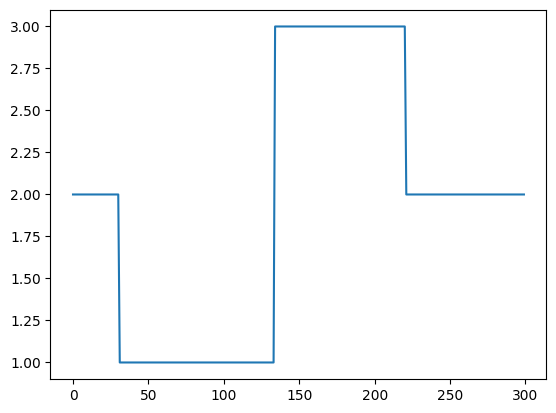

In [11]:

def aggregate(output):
    total = []
    for i in range(len(output)):
        prev = int(output[i][0])
        for j in range(1, len(output[i])):
            if output[i][j] != prev and output[i][j] != 0:
                total.append(prev)
                prev = int(output[i][j])
        total.append(prev)
    return total

# test:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels, labels_count in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels_count = torch.tensor(labels_count).to(device)
        images = images.float()
        outputs = model(images)
        # print(outputs.shape)
        # print(outputs)
        outputs = F.softmax(outputs, dim=2)
        input_lengths = torch.full((images.shape[0],), images.shape[1], dtype=torch.long)
        loss = criterion(outputs.permute(1, 0, 2), labels.cpu(),  input_lengths.cpu(), labels_count.cpu())
        _, predicted = torch.max(outputs.data, 2)
        total += labels.size(0)
        i = 1
        print(predicted[i])
        print(labels_count)
        print(labels[labels_count[i-1]: labels_count[i-1]+labels_count[i]])
        print(test_loader.dataset.sec_labels[i])
        plt.plot(test_loader.dataset.sec_labels[i])
        s = aggregate(predicted)
        
        print(s,)
        print(labels.tolist())
        break